# Sampling SigClust

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sigclust

In [3]:
import numpy as np
np.random.seed(824)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
toy = pd.read_csv('examples/sigclust_toy_data.csv', header=None)

In [5]:
toy = toy.T
toy.columns = ['label', 'x1', 'x2']

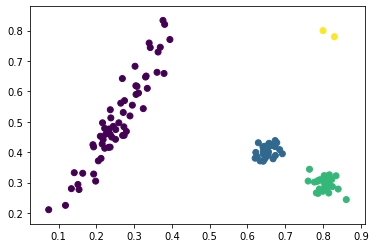

In [6]:
plt.scatter(toy['x1'], toy['x2'], c=toy['label'])

## SigClust does not split the stretched gaussian from the outliers

In [40]:
longcluster_and_outliers = toy[toy['label'].isin((1,4))]

In [41]:
sc2 = sigclust.SigClust()
sc2.fit(longcluster_and_outliers[['x1', 'x2']], longcluster_and_outliers['label'])
print("p-value: {} \nz-score: {}".format(sc2.p_value, sc2.z_score))

p-value: 1.0 
z-score: 6.257242801333375


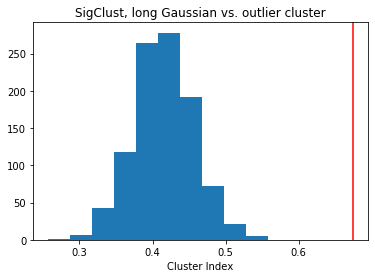

In [42]:
sample_ci2 = sigclust.compute_cluster_index(longcluster_and_outliers[['x1', 'x2']], longcluster_and_outliers['label'])
plt.hist(sc2.simulated_cluster_indices)
plt.axvline(sample_ci2, color='red')
plt.title("SigClust, long Gaussian vs. outlier cluster")
plt.xlabel("Cluster Index")
plt.show()

In [65]:
cov = np.cov(circular_clusters[['x1', 'x2']].T)
cov

array([[ 0.00619272, -0.00417837],
       [-0.00417837,  0.00342364]])

In [70]:
evals = np.linalg.eigvals(cov)

In [48]:
np.dot(circular_clusters[['x1', 'x2']].T, circular_clusters[['x1', 'x2']])

array([[32.26791154, 15.09194579],
       [15.09194579,  7.57659997]])

In [71]:
sim_matrix=np.random.multivariate_normal(np.zeros(2), np.diag(evals), size=60)

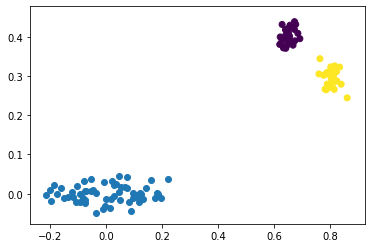

In [72]:
plt.scatter(circular_clusters['x1'], circular_clusters['x2'], c=circular_clusters['label'])
plt.scatter(sim_matrix[:, 0], sim_matrix[:, 1])

In [73]:
sim_matrix2 = np.random.multivariate_normal(circular_clusters[['x1', 'x2']].mean(), cov, size=60)

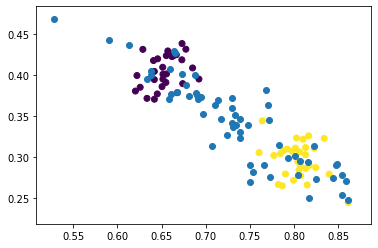

In [74]:
plt.scatter(circular_clusters['x1'], circular_clusters['x2'], c=circular_clusters['label'])
plt.scatter(sim_matrix2[:, 0], sim_matrix2[:, 1])

In [15]:
stretched_gaussian = toy[toy['label']==1]
outliers = toy[toy['label']==4]

In [13]:
CIs = []
for i in range(1):
    sc = sigclust.SigClust(num_simulations=100)
    sc.fit(newdata[:, 1:3], newdata[:,0])
    CIs.extend(sc.simulated_cluster_indices)

In [34]:
CIs = []
for i in range(100):
    sample_from_majority_class = toy[toy['label']==1][['x1','x2']].sample(10, replace=False)
    new_data = np.concatenate([sample_from_majority_class.values, more_outliers])
    new_labels = np.concatenate([np.repeat(1, 10), np.repeat(2, 10)])
    sc = sigclust.SigClust(100)
    sc.fit(new_data, new_labels)
    CIs.extend(sc.simulated_cluster_indices)

In [35]:
len(CIs)

10000

In [37]:
data_ci = sigclust.compute_cluster_index(newdata[:, 1:3], newdata[:, 0])

In [38]:
z = (data_ci-np.mean(CIs)) / np.std(CIs, ddof=1)
z

6.538701804597116

So for the sampling idea, I got a z score of positive 6.5. So this definitely isn't working.

# Now, I test the weighted sigclust versus the sampling sigclust

In [13]:
more_outliers = np.random.multivariate_normal(outliers.mean(), np.diag([.001,.001]), size=10)
more_outliers = pd.DataFrame(more_outliers, columns=['x1', 'x2'])
more_outliers['labels'] = 5
more_outliers.head()

,x1,x2,labels
0,0.742491,0.781414,5
1,0.844717,0.783821,5
2,0.776991,0.758547,5
3,0.833438,0.731717,5
4,0.779900,0.811712,5


In [14]:
stretched_gaussian

,x1,x2
0,0.268958,0.642379
1,0.271328,0.530824
2,0.151373,0.293943
3,0.324291,0.543477
4,0.250826,0.442557
5,0.369293,0.745335
6,0.205353,0.371656
7,0.251443,0.474644
8,0.259604,0.496874
9,0.215469,0.427056


In [11]:
labs = np.tile(5, (10,1))
temp = np.concatenate([labs, more_outliers], axis=1)
stretched_gaussian_plus_10_outliers = np.concatenate([toy[toy['label']==1], temp])
stretched_gaussian_plus_10_outliers

array([[1.        , 0.26895796, 0.64237913],
       [1.        , 0.27132839, 0.53082393],
       [1.        , 0.15137296, 0.29394267],
       [1.        , 0.32429101, 0.54347711],
       [1.        , 0.25082636, 0.4425566 ],
       [1.        , 0.36929263, 0.74533452],
       [1.        , 0.20535268, 0.37165578],
       [1.        , 0.25144301, 0.47464416],
       [1.        , 0.25960373, 0.49687362],
       [1.        , 0.21546877, 0.42705626],
       [1.        , 0.274579  , 0.56975864],
       [1.        , 0.30511453, 0.5900817 ],
       [1.        , 0.23846988, 0.51296048],
       [1.        , 0.39476585, 0.77075434],
       [1.        , 0.14165593, 0.33275173],
       [1.        , 0.36342333, 0.72961135],
       [1.        , 0.23654484, 0.41681614],
       [1.        , 0.07395295, 0.21091652],
       [1.        , 0.21650014, 0.49686092],
       [1.        , 0.21811954, 0.44183905],
       [1.        , 0.16403977, 0.33087632],
       [1.        , 0.37927897, 0.65915361],
       [1.

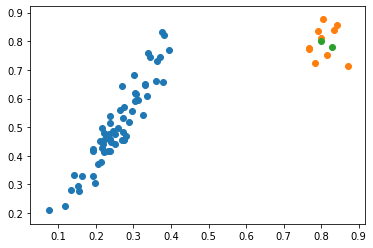

In [12]:
plt.scatter(stretched_gaussian['x1'], stretched_gaussian['x2'])
plt.scatter(more_outliers[:,0], more_outliers[:,1])
plt.scatter(outliers['x1'], outliers['x2'])

In [ ]:
def bind_sample(sample):
    labs = np.tile(5, (10,1))
    temp = np.concatenate([labs, more_outliers], axis=1)
    return np.concatenate(sample, temp)

In [ ]:
fig, axes = plt.subplots(2, 4, constrained_layout=True)
i = 0
sample = stretched_gaussian.sample(10, repeat=False)

mean = stretched_gaussian_plus_10_outliers.mean()

sc = sigclust.SigClust(100)
sc.
    


In [15]:
sc = sigclust.SigClust()
sc.fit(newdata[:, 1:3], newdata[:,0])

Text(0.5, 1.0, 'Regular SigClust')

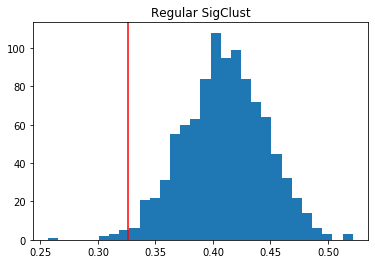

In [30]:
plt.hist(sc.simulated_cluster_indices, bins=30)
sample_ci = sigclust.compute_cluster_index(newdata[:, 1:3], newdata[:,0])
plt.axvline(sample_ci, color='red')
plt.title("Regular SigClust")

In [17]:
ssc = sigclust.SamplingSigClust()
ssc.fit(newdata[:, 1:3], newdata[:,0])

Text(0.5, 1.0, 'Sampling SigClust')

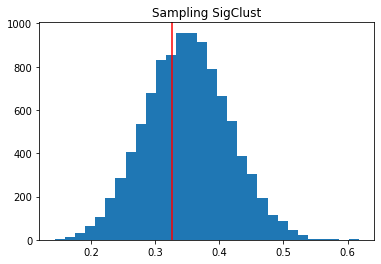

In [29]:
plt.hist(ssc.simulated_cluster_indices, bins=30)
plt.axvline(sample_ci, color='red')
plt.title("Sampling SigClust")

In [22]:
wsc = sigclust.WeightedSigClust(conservative=True)
wsc.fit(newdata[:, 1:3], newdata[:,0])

Text(0.5, 1.0, 'Conservative Weighted SigClust (size = n1+n2)')

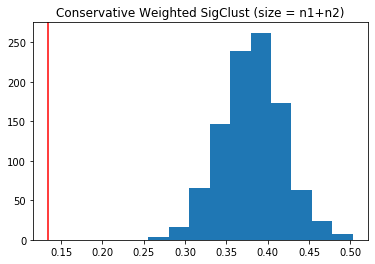

In [33]:
plt.hist(wsc.simulated_cluster_indices)
weighted_ci = sigclust.compute_weighted_cluster_index(stretched_gaussian, more_outliers)
plt.axvline(weighted_ci, color='red')
plt.title("Conservative Weighted SigClust (size = n1+n2)")

In [24]:
wsc2 = sigclust.WeightedSigClust(conservative=False)
wsc2.fit(newdata[:, 1:3], newdata[:,0])

Text(0.5, 1.0, 'Weighted SigClust (size = 2 * n1)')

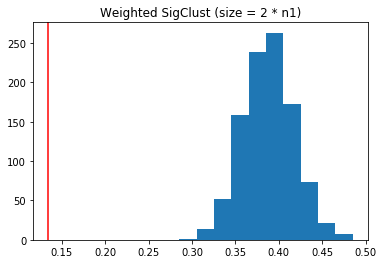

In [32]:
plt.hist(wsc2.simulated_cluster_indices)
plt.axvline(weighted_ci, color='red')
plt.title("Weighted SigClust (size = 2 * n1)")